## *"Understanding the Difficulty of Training Deep Feedforward Neural Networks"* using PyTorch.

### **Step 1: Dataset Preparation**
- The original paper used datasets like MNIST.
- We'll load MNIST using `torchvision.datasets` and preprocess it.

---

### **Step 2: Implementing Neural Networks**
- Define fully connected feedforward networks with **sigmoid, tanh, and ReLU** activations.
- Apply **Xavier (Glorot) and Kaiming initialization**.
- Measure the effect of different initializations on activations.

---

### **Step 3: Training and Observing Activations**
- Train the networks with standard optimizers like **SGD**.
- Record activation distributions after each layer to check for **saturation** and **linearity**.
- Use **histograms** to visualize activations.

---

### **Step 4: Compute Metrics**
- Measure **gradient magnitudes** to detect vanishing or exploding gradients.
- Track **loss curves**.
- Compare **training speed and final accuracy**.

---

### **Step 5: Perplexity Calculation (Optional)**
- If dealing with text, use a softmax output layer.
- Compute **perplexity = exp(cross-entropy loss)**.

### **Step 1: Dataset Preparation**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define transformations (convert to tensor & normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and Std of MNIST
])

# Download and load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check dataset shape
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels shape: {labels.shape}")


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [02:21<00:00, 69.9kB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 32.6kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:54<00:00, 30.4kB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 15.1kB/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Batch shape: torch.Size([64, 1, 28, 28]), Labels shape: torch.Size([64])


### **Step 2: Implementing Neural Networks**

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class FeedforwardNN(nn.Module):
    def __init__(self, activation='relu', init_method='xavier'):
        super().__init__()

        self.activation_name = activation
        self.init_method = init_method

        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)

        self._initialize_weights()

    def forward(self, x):
        x = x.view(x.size(0), -1)

        if self.activation_name == 'sigmoid':
            x = torch.sigmoid(self.fc1(x))
            x = torch.sigmoid(self.fc2(x))
        elif self.activation_name == 'tanh':
            x = torch.tanh(self.fc1(x))
            x = torch.tanh(self.fc2(x))
        else:  # Default to ReLU
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))

        x = self.fc3(x)
        return x

    def _initialize_weights(self):
        for layer in [self.fc1, self.fc2, self.fc3]:
            if self.init_method == 'xavier':
                nn.init.xavier_uniform_(layer.weight)
            elif self.init_method == 'kaiming':
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
            else:
                nn.init.normal_(layer.weight, mean=0.0, std=0.1)
        nn.init.zeros_(layer.bias)

In [7]:
# Create models with different activation functions and initializations
model_relu_xavier = FeedforwardNN(activation='relu', init_method='xavier')
model_relu_kaiming = FeedforwardNN(activation='relu', init_method='kaiming')
model_sigmoid_xavier = FeedforwardNN(activation='sigmoid', init_method='xavier')
model_tanh_xavier = FeedforwardNN(activation='tanh', init_method='xavier')

# Print initialized weights for verification
print("First layer weights (ReLU + Xavier):", model_relu_xavier.fc1.weight[0][:10])
print("First layer weights (ReLU + Kaiming):", model_relu_kaiming.fc1.weight[0][:10])

First layer weights (ReLU + Xavier): tensor([-0.0170, -0.0460,  0.0547, -0.0164, -0.0376, -0.0101,  0.0685,  0.0132,
        -0.0509, -0.0562], grad_fn=<SliceBackward0>)
First layer weights (ReLU + Kaiming): tensor([-7.4008e-02, -5.5403e-02, -5.3340e-02,  5.2805e-02, -2.7636e-02,
        -1.5504e-02,  3.4897e-02, -1.0132e-02, -2.6389e-02, -2.0899e-05],
       grad_fn=<SliceBackward0>)


### Step 3: Visualizing Activations to Check for Saturation

In [8]:
import torch
import matplotlib.pyplot as plt

# Function to register hooks for capturing activations
activations = {}

def activation_hook(layer_name):
    def hook(module, input, output):
        activations[layer_name] = output.detach().cpu().numpy()
    return hook


In [9]:
# Select a model (e.g., ReLU with Xavier initialization)
model = FeedforwardNN(activation='relu', init_method='xavier')

# Register hooks on hidden layers
model.fc1.register_forward_hook(activation_hook('fc1'))
model.fc2.register_forward_hook(activation_hook('fc2'))


In [10]:
# Generate random input data (like an image batch)
x = torch.randn(1000, 28*28)  # 1000 samples of 784 features
_ = model(x)  # Forward pass to trigger hooks


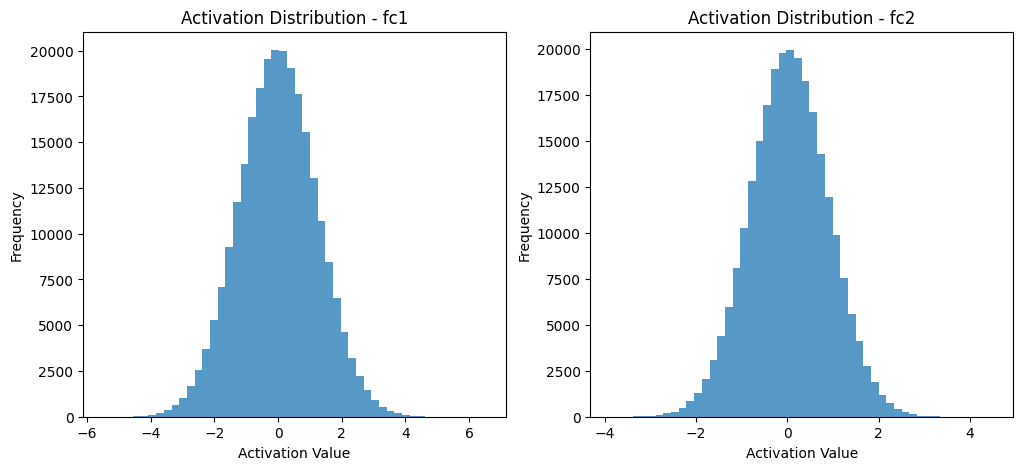

In [11]:
def plot_activations(activations):
    plt.figure(figsize=(12, 5))
    
    for i, (layer, act) in enumerate(activations.items()):
        plt.subplot(1, 2, i+1)
        plt.hist(act.flatten(), bins=50, alpha=0.75)
        plt.title(f'Activation Distribution - {layer}')
        plt.xlabel('Activation Value')
        plt.ylabel('Frequency')

    plt.show()

plot_activations(activations)


### Step 4: Training the Model and Observing Loss Dynamics

In [12]:
import torch.optim as optim

def train_model(model, epochs=10, lr=0.01):
    optimizer = optim.SGD(model.parameters(), lr=lr)
    loss_fn = torch.nn.CrossEntropyLoss()

    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Generate random data and labels
        x = torch.randn(256, 28*28)  # Batch of 256 images
        y = torch.randint(0, 10, (256,))  # Random labels (10 classes)
        
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    return losses


In [13]:
import numpy as np

# Compare Xavier vs. Kaiming initialization
methods = ['xavier', 'kaiming']
losses_dict = {}

for method in methods:
    print(f"\nTraining with {method} initialization...")
    model = FeedforwardNN(activation='relu', init_method=method)
    losses_dict[method] = train_model(model)



Training with xavier initialization...
Epoch 1/10, Loss: 2.5533
Epoch 2/10, Loss: 2.4737
Epoch 3/10, Loss: 2.4835
Epoch 4/10, Loss: 2.5526
Epoch 5/10, Loss: 2.5294
Epoch 6/10, Loss: 2.5821
Epoch 7/10, Loss: 2.5033
Epoch 8/10, Loss: 2.4966
Epoch 9/10, Loss: 2.5116
Epoch 10/10, Loss: 2.4505

Training with kaiming initialization...
Epoch 1/10, Loss: 3.3134
Epoch 2/10, Loss: 3.1532
Epoch 3/10, Loss: 2.7689
Epoch 4/10, Loss: 2.7693
Epoch 5/10, Loss: 2.8378
Epoch 6/10, Loss: 2.7715
Epoch 7/10, Loss: 2.7345
Epoch 8/10, Loss: 2.7059
Epoch 9/10, Loss: 2.7284
Epoch 10/10, Loss: 2.8258


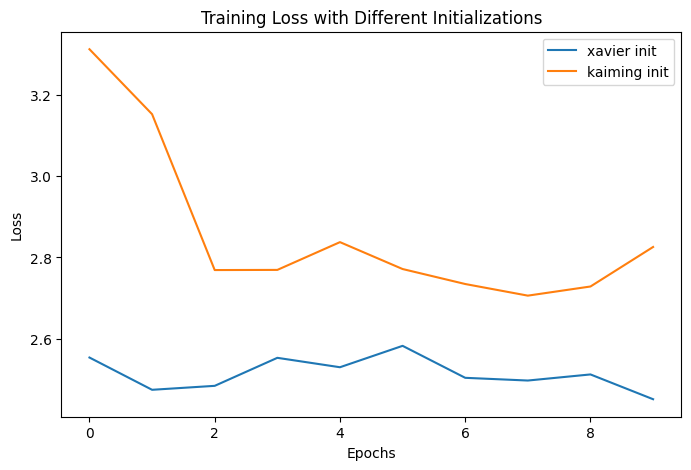

In [14]:
plt.figure(figsize=(8, 5))

for method, losses in losses_dict.items():
    plt.plot(losses, label=f"{method} init")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss with Different Initializations')
plt.legend()
plt.show()
